<a href="https://colab.research.google.com/github/camulro/Aprendizaje-II/blob/sesi%C3%B3n2/Transfer_AvP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Import data from Kaggle

You must generate a kaggle.json file from your profile in Kaggle (API section) and download it somewhere in your machine.

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
#select you kaggle.json file

KeyboardInterrupt: ignored

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# Make directory named kaggle and copy kaggle.json file there.
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
! kaggle datasets download -d pmigdal/alien-vs-predator-images

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [6]:
! mkdir avp_data/
! unzip alien-vs-predator-images.zip -d avp_data/

unzip:  cannot find or open alien-vs-predator-images.zip, alien-vs-predator-images.zip.zip or alien-vs-predator-images.zip.ZIP.


In [7]:
data_dir = "./avp_data/data"
input_shape = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}

image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'validation']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['train', 'validation']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

print(dataset_sizes)
class_names = image_datasets['train'].classes
print(class_names)


FileNotFoundError: ignored

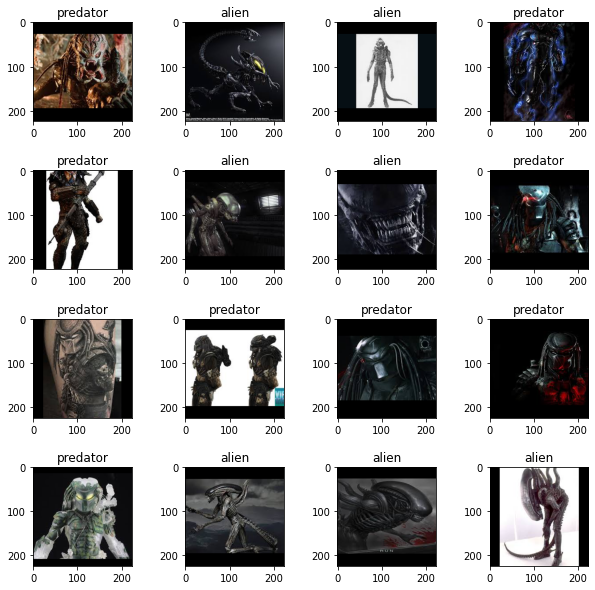

In [ ]:
images, labels = next(iter(dataloaders['train']))

rows = 4
columns = 4
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
for i in range(16):
    fig.add_subplot(rows, columns, i+1)
    plt.title(class_names[labels[i]])
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    plt.imshow(img)
plt.show()

# VGG19 model

In [ ]:
## Load the model based on VGG19
vgg_based = torchvision.models.vgg19(pretrained=True)
print(vgg_based)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
## freeze the layers
for param in vgg_based.parameters():
    param.requires_grad = False

# Modify the last layer
number_features = vgg_based.classifier[6].in_features # 4096
layers = list(vgg_based.classifier.children())[:-1] # Remove last layer
layers.extend([torch.nn.Linear(number_features, len(class_names))])
vgg_based.classifier = torch.nn.Sequential(*layers)

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
epochs = 25
model = vgg_based
train_loss = []
acc_list=[]
model.train()

for epoch in range(epochs):
    
        running_loss = 0
        train_correct = 0
        train_total = 0

        # Iterate over data.
        for i, data in enumerate(dataloaders['train']):
            inputs , labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
          
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_total += labels.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
        
        acc_list.append(train_correct/dataset_sizes['train'])     
        train_loss.append(running_loss / dataset_sizes['train']) 
        print('Epoch: {} Loss: {:.4f} Acc: {:.4f}'.format(
                epoch+1, running_loss / dataset_sizes['train'], train_correct/dataset_sizes['train']))

            


Epoch: 1 Loss: 0.4948 Acc: 0.7291
Epoch: 2 Loss: 0.2454 Acc: 0.8919
Epoch: 3 Loss: 0.2275 Acc: 0.8934
Epoch: 4 Loss: 0.2220 Acc: 0.9063
Epoch: 5 Loss: 0.2043 Acc: 0.9078
Epoch: 6 Loss: 0.1864 Acc: 0.9135
Epoch: 7 Loss: 0.1762 Acc: 0.9207
Epoch: 8 Loss: 0.1731 Acc: 0.9251
Epoch: 9 Loss: 0.1749 Acc: 0.9222
Epoch: 10 Loss: 0.1489 Acc: 0.9409
Epoch: 11 Loss: 0.1612 Acc: 0.9251
Epoch: 12 Loss: 0.1467 Acc: 0.9424
Epoch: 13 Loss: 0.1437 Acc: 0.9409
Epoch: 14 Loss: 0.1256 Acc: 0.9568
Epoch: 15 Loss: 0.1491 Acc: 0.9424
Epoch: 16 Loss: 0.1440 Acc: 0.9366
Epoch: 17 Loss: 0.1206 Acc: 0.9510
Epoch: 18 Loss: 0.1321 Acc: 0.9553
Epoch: 19 Loss: 0.1315 Acc: 0.9424
Epoch: 20 Loss: 0.1303 Acc: 0.9452
Epoch: 21 Loss: 0.1295 Acc: 0.9438
Epoch: 22 Loss: 0.1220 Acc: 0.9539
Epoch: 23 Loss: 0.1245 Acc: 0.9467
Epoch: 24 Loss: 0.1204 Acc: 0.9568
Epoch: 25 Loss: 0.1153 Acc: 0.9625


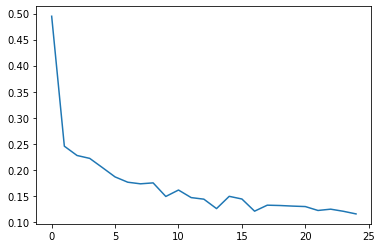

In [ ]:
plt.plot(np.array(train_loss))
plt.show()

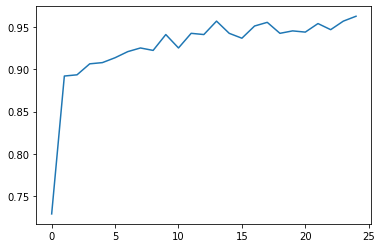

In [ ]:
plt.plot(np.array(acc_list))
plt.show()

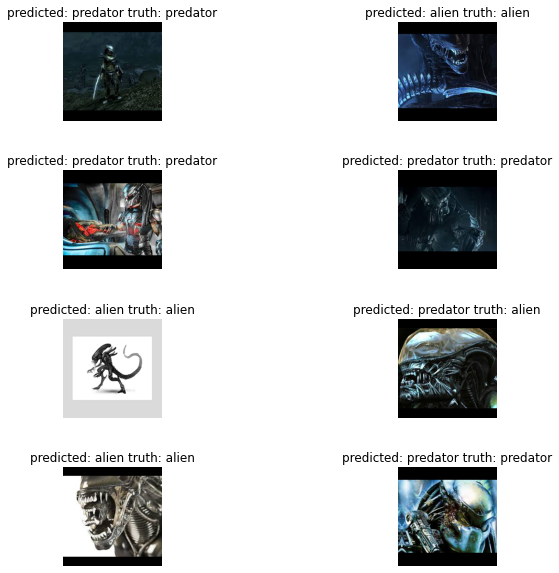

In [ ]:
model.eval()

dataiter = iter(dataloaders['validation'])
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

# print images
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
num_of_images = 8
for index in range(1, num_of_images+1):
    plt.subplot(4, 2, index)
    plt.axis('off')
    img = images[index-1].cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    plt.imshow(img)
    plt.title('predicted: {} truth: {}'.format(class_names[preds[index-1]], class_names[labels[index-1]]))


In [ ]:
correct = 0
total = 0
with torch.no_grad(): #para inferir no lo necesitamos
    for data in dataloaders['validation']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 92 %


# ResNet50

In [ ]:
## Load the model based on ReNet50
rn50_based = torchvision.models.resnet50(pretrained=True)
print(rn50_based)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
## freeze the layers
for param in rn50_based.parameters():
    param.requires_grad = False

# Modify the last layer
rn50_based.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2))

rn50_based = rn50_based.to(device)

print(rn50_based)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rn50_based.fc.parameters(),lr=0.001)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
epochs = 25
model = rn50_based
train_loss = []
acc_list=[]
model.train()

for epoch in range(epochs):
    
        running_loss = 0
        train_correct = 0
        train_total = 0

        # Iterate over data.
        for i, data in enumerate(dataloaders['train']):
            inputs , labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
          
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_total += labels.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
        
        acc_list.append(train_correct/dataset_sizes['train'])     
        train_loss.append(running_loss / dataset_sizes['train']) 
        print('Epoch: {} Loss: {:.4f} Acc: {:.4f}'.format(
                epoch+1, running_loss / dataset_sizes['train'], train_correct/dataset_sizes['train']))



Epoch: 1 Loss: 0.6318 Acc: 0.6081
Epoch: 2 Loss: 0.3557 Acc: 0.8573
Epoch: 3 Loss: 0.2429 Acc: 0.9121
Epoch: 4 Loss: 0.2283 Acc: 0.9135
Epoch: 5 Loss: 0.2015 Acc: 0.9222
Epoch: 6 Loss: 0.1314 Acc: 0.9568
Epoch: 7 Loss: 0.1617 Acc: 0.9280
Epoch: 8 Loss: 0.1423 Acc: 0.9467
Epoch: 9 Loss: 0.1467 Acc: 0.9380
Epoch: 10 Loss: 0.1053 Acc: 0.9597
Epoch: 11 Loss: 0.0991 Acc: 0.9625
Epoch: 12 Loss: 0.1038 Acc: 0.9640
Epoch: 13 Loss: 0.0839 Acc: 0.9683
Epoch: 14 Loss: 0.1032 Acc: 0.9654
Epoch: 15 Loss: 0.0933 Acc: 0.9611
Epoch: 16 Loss: 0.0942 Acc: 0.9597
Epoch: 17 Loss: 0.1477 Acc: 0.9409
Epoch: 18 Loss: 0.1169 Acc: 0.9582
Epoch: 19 Loss: 0.0742 Acc: 0.9741
Epoch: 20 Loss: 0.1154 Acc: 0.9568
Epoch: 21 Loss: 0.0689 Acc: 0.9726
Epoch: 22 Loss: 0.0747 Acc: 0.9625
Epoch: 23 Loss: 0.0814 Acc: 0.9726
Epoch: 24 Loss: 0.0725 Acc: 0.9669
Epoch: 25 Loss: 0.1248 Acc: 0.9481


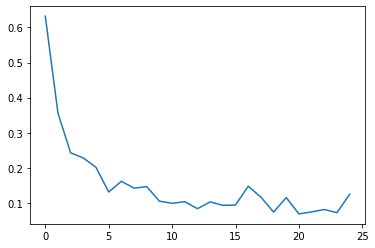

In [ ]:
plt.plot(np.array(train_loss))
plt.show()

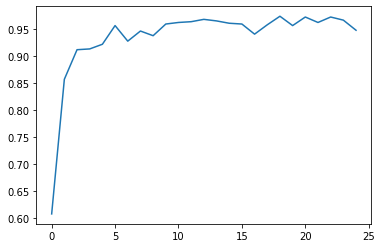

In [ ]:
plt.plot(np.array(acc_list))
plt.show()

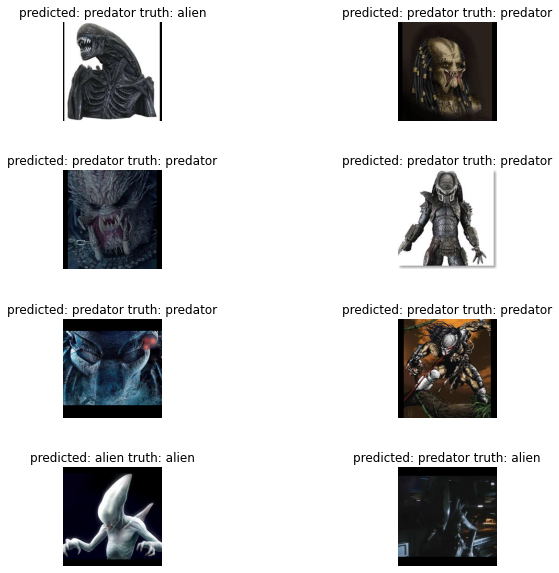

In [ ]:
model.eval()

dataiter = iter(dataloaders['validation'])
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

# print images
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
num_of_images = 8
for index in range(1, num_of_images+1):
    plt.subplot(4, 2, index)
    plt.axis('off')
    img = images[index-1].cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    plt.imshow(img)
    plt.title('predicted: {} truth: {}'.format(class_names[preds[index-1]], class_names[labels[index-1]]))


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['validation']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 90 %
